## Starting Spark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)


24/07/03 01:30:48 WARN Utils: Your hostname, MacBook-Pro-Sunith.local resolves to a loopback address: 127.0.0.1; using 10.10.67.15 instead (on interface en0)
24/07/03 01:30:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/03 01:30:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Importing and Basic Cleaning

In [6]:
# import pandas as pd

file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# description_path = '/Users/sunith/dss_project/data/DescriptionDataCoSupplyChain.csv'
# df_description = spark.read.csv(description_path, header=True, inferSchema=True)
# df = pd.read_csv(file_path, encoding='latin1')
df.show()

24/07/03 01:31:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [7]:
from pyspark.sql.functions import col, sum as _sum
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [8]:
# Some house cleaning where the the column names are standardized
import pyspark.sql.functions as F
for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))


In [9]:

df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)")    
df.createOrReplaceTempView("my_table")
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|  delivery_status|late_delivery_risk|category_id| category_name| customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|depa

In [21]:
# spark.sql("""Select product_card_id, sum(order_item_quantity) as quantity
#           from my_table
#           group by product_card_id
#           order by quantity desc
#           """).show()
# Item with most quantity ordered id = 365
# spark.sql("""select
#           order_country,
#           sum(order_item_quantity) as quantity
#           from my_table
#           where product_card_id = 365
#           group by order_country
#           order by quantity desc
#           """).show()
spark.sql("""Select order_country,
          count(order_country) as count
          from my_table
          group by order_country
          order by count desc""").show()

spark.sql("""Select customer_country,
          count(customer_country) as count
          from my_table
          group by customer_country
          order by count desc""").show()

+--------------------+-----+
|       order_country|count|
+--------------------+-----+
|      Estados Unidos|24840|
|             Francia|13222|
|              M�xico|13172|
|            Alemania| 9564|
|           Australia| 8497|
|              Brasil| 7987|
|         Reino Unido| 7302|
|               China| 5758|
|              Italia| 4989|
|               India| 4783|
|           Indonesia| 4204|
|              Espa�a| 3868|
|         El Salvador| 3726|
|Rep�blica Dominicana| 3669|
|            Honduras| 3629|
|                Cuba| 3534|
|             Turqu�a| 3395|
|           Nicaragua| 3046|
|           Guatemala| 2778|
|             Nigeria| 2309|
+--------------------+-----+
only showing top 20 rows

+----------------+------+
|customer_country| count|
+----------------+------+
|         EE. UU.|111146|
|     Puerto Rico| 69373|
+----------------+------+



In [40]:
products = spark.sql("""
                    SELECT product_name,
                        product_card_id,
                        Count(product_card_id)   AS count,
                        Sum(order_item_quantity) AS quantity,
                        Max(product_price)       AS price,
                        quantity * price         AS calc_sales,
                        Sum(sales)               AS total_sales
                    FROM   my_table
                    GROUP  BY product_name,
                            product_card_id
                    ORDER  BY price DESC 
                """)

products.show(10)
# products.write.mode("overwrite").option("header", "true").csv("product_analysis.csv")
products.toPandas().to_csv('product_analysis.csv', encoding='utf-8', index=False)

+--------------------+---------------+-----+--------+-----------+------------------+------------------+
|        product_name|product_card_id|count|quantity|      price|        calc_sales|       total_sales|
+--------------------+---------------+-----+--------+-----------+------------------+------------------+
| SOLE E35 Elliptical|            208|   15|      15| 1999.98999|       29999.84985|29999.849850000002|
|         Dell Laptop|           1351|  442|     442|     1500.0|          663000.0|          663000.0|
| SOLE E25 Elliptical|             60|   10|      10|999.9899902|       9999.899902| 9999.899902000001|
|Bushnell Pro X7 J...|            860|   11|      11|599.9899902|      6599.8898922|      6599.8898922|
|Bowflex SelectTec...|            226|   10|      10|599.9899902| 5999.899901999999| 5999.899901999999|
|          Lawn mower|           1355|  484|     484|532.5800171|257768.72827639998| 257768.7282764002|
|    Porcelain crafts|           1353|  484|     484| 461.480011

In [36]:
orders = spark.sql("""
            SELECT 
                order_id,
                collect_list(product_card_id) AS product_ids
            FROM 
                my_table
            GROUP BY 
                order_id;
          """)
orders.show(10)
orders.toPandas().to_csv('order_details.csv', encoding='utf-8', index=False)

+--------+--------------------+
|order_id|         product_ids|
+--------+--------------------+
|       1|               [957]|
|       2|    [1073, 403, 502]|
|       4|[897, 502, 365, 1...|
|       5|[403, 957, 957, 3...|
|       7|    [957, 1073, 926]|
|       8|[1014, 502, 365, ...|
|       9|   [1073, 1073, 191]|
|      10|[403, 917, 1073, ...|
|      11|[365, 191, 627, 1...|
|      12|[134, 1014, 957, ...|
+--------+--------------------+
only showing top 10 rows



In [26]:
df.dtypes

[('type', 'string'),
 ('days_for_shipping_(real)', 'int'),
 ('days_for_shipment_(scheduled)', 'int'),
 ('benefit_per_order', 'double'),
 ('sales_per_customer', 'double'),
 ('delivery_status', 'string'),
 ('late_delivery_risk', 'int'),
 ('category_id', 'int'),
 ('category_name', 'string'),
 ('customer_city', 'string'),
 ('customer_country', 'string'),
 ('customer_id', 'int'),
 ('customer_segment', 'string'),
 ('customer_state', 'string'),
 ('customer_zipcode', 'int'),
 ('department_id', 'int'),
 ('department_name', 'string'),
 ('market', 'string'),
 ('order_city', 'string'),
 ('order_country', 'string'),
 ('order_customer_id', 'int'),
 ('order_id', 'int'),
 ('order_item_cardprod_id', 'int'),
 ('order_item_discount', 'double'),
 ('order_item_discount_rate', 'double'),
 ('order_item_id', 'int'),
 ('order_item_product_price', 'double'),
 ('order_item_profit_ratio', 'double'),
 ('order_item_quantity', 'int'),
 ('sales', 'double'),
 ('order_item_total', 'double'),
 ('order_profit_per_order',

In [6]:
df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+------------------+------------------+------------------+-------------+----------------+----------------+----------------+------------------+-----------------+------------------+---------------+------+--------------+-------------+-----------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+------------------+-------------------+--------------------+------------------+--------------+
|summary|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)| benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|       category_id|     category_name|customer_city|customer_country|     customer

## Data Exploration

Wanted to see if a customer appears multiple times in the dataset

In [8]:
spark.sql("Select customer_id From my_table GROUP BY customer_id having count(customer_id) > 1 limit 5").show()

+-----------+
|customer_id|
+-----------+
|       3997|
|       6466|
|        471|
|       6397|
|       5518|
+-----------+



In [9]:
df.filter(df.customer_id == 3997).show()

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+-------------+--------------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+--------------------+------------+-------------+---------------+-------------------+--------------------+-------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id|       category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipc

We are trying to see if there are orders extending to multiple rows.

In [10]:
spark.sql("Select order_id From my_table GROUP BY order_id having count(order_id) > 1 limit 5").show()

+--------+
|order_id|
+--------+
|   55155|
|   67753|
|   29993|
|   23571|
|   37111|
+--------+



We can see that order is broken down into item level. Where each order can contain multiple items.

In [112]:
# We can see that there are multiple items in one order and they are in multiple rows
df.filter(df.order_id == 67753).select('customer_id', 'order_status',
                                       'order_id','sales', 
                                       'benefit_per_order','product_name',
                                       'product_price','shipping_mode',
                                       'product_status', 'order_profit_per_order').show() 

+-----------+------------+--------+-----------+-----------------+--------------------+-------------+-------------+--------------+----------------------+
|customer_id|order_status|order_id|      sales|benefit_per_order|        product_name|product_price|shipping_mode|product_status|order_profit_per_order|
+-----------+------------+--------+-----------+-----------------+--------------------+-------------+-------------+--------------+----------------------+
|       1566|    COMPLETE|   67753|399.9899902|      105.5999985|GoPro HERO3+ Blac...|  399.9899902| Second Class|             0|           105.5999985|
|       1566|    COMPLETE|   67753|299.9899902|            144.0|      Total Gym 1400|  299.9899902| Second Class|             0|                 144.0|
|       1566|    COMPLETE|   67753|129.9900055|      37.34999847|Nike Men's CJ Eli...|  129.9900055| Second Class|             0|           37.34999847|
|       1566|    COMPLETE|   67753|99.95999908|      30.73999977|O'Brien Men's Neo

The columns that can be used for training an ML model.

In [8]:
# Pyspark distinct selection from a dataframe
df.select(df.late_delivery_risk).distinct().show()

+------------------+
|late_delivery_risk|
+------------------+
|                 1|
|                 0|
+------------------+



In [35]:
# Pyspark distinct selection from a dataframe
df.select(df.product_status).distinct().show()

+--------------+
|product_status|
+--------------+
|             0|
+--------------+



In [9]:
df.filter(df.order_country == 'EE. UU.').show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+------------+-------------+--------------------------+-------------+
|type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|delivery_status|late_delivery_risk|category_id|category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_name|m

Counts Based on categories for quick analysis

In [13]:
df.groupBy('delivery_status').count().orderBy('count', ascending=False).show()

+-----------------+-----+
|  delivery_status|count|
+-----------------+-----+
|    Late delivery|98977|
| Advance shipping|41592|
| Shipping on time|32196|
|Shipping canceled| 7754|
+-----------------+-----+



In [21]:
spark.sql("""
          Select customer_segment, 
          sum(sales) as sales, 
          sum(order_profit_per_order) as profit,
          count(distinct(customer_id)) as cust_count
          From my_table 
          GROUP BY customer_segment
          ORDER BY sales DESC
          """).show()

+----------------+--------------------+------------------+----------+
|customer_segment|               sales|            profit|cust_count|
+----------------+--------------------+------------------+----------+
|        Consumer|1.9095790155174054E7|2073487.6719135328|     10695|
|       Corporate|1.1168406842990492E7|1202574.9615065993|      6239|
|     Home Office|  6520538.0152156735| 690840.3406302303|      3718|
+----------------+--------------------+------------------+----------+



In [25]:
spark.sql("""
          Select shipping_mode, 
          sum(sales) as sales, 
          sum(order_profit_per_order) as profit,
          count(distinct(customer_id)) as cust_count
          From my_table 
          GROUP BY shipping_mode
          ORDER BY sales DESC
          """).show()

+--------------+--------------------+------------------+----------+
| shipping_mode|               sales|            profit|cust_count|
+--------------+--------------------+------------------+----------+
|Standard Class|2.2022391879808668E7|2370454.4528039624|     16578|
|  Second Class|   7145444.818358937| 750308.1702654322|      8969|
|   First Class|   5674369.758202563| 643121.9207390624|      7594|
|      Same Day|  1942528.5570090855|203018.43024189796|      3208|
+--------------+--------------------+------------------+----------+



In [16]:
df.groupBy('customer_segment').count().orderBy('count', ascending=False).show()

+----------------+-----+
|customer_segment|count|
+----------------+-----+
|        Consumer|93504|
|       Corporate|54789|
|     Home Office|32226|
+----------------+-----+



In [19]:
df1 = df.groupBy('order_status').count().orderBy('count', ascending=False).toPandas()
df1

,order_status,count
0,COMPLETE,59491
1,PENDING_PAYMENT,39832
2,PROCESSING,21902
3,PENDING,20227
4,CLOSED,19616
5,ON_HOLD,9804
6,SUSPECTED_FRAUD,4062
7,CANCELED,3692
8,PAYMENT_REVIEW,1893


Text(0.5, 1.0, 'Order Status')

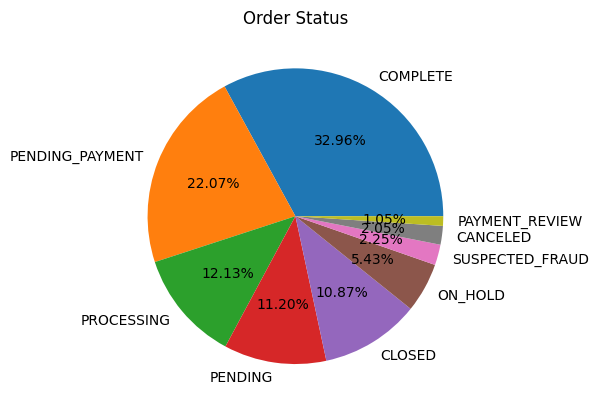

In [21]:
label=["COMPLETE","PENDING_PAYMENT","PROCESSING","PENDING","CLOSED","ON_HOLD","SUSPECTED_FRAUD","CANCELED","PAYMENT_REVIEW"]
plt.pie(df1['count'],labels=label, autopct='%1.2f%%')
plt.title("Order Status")

In [11]:
df.groupBy('order_country').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|       order_country|count|
+--------------------+-----+
|      Estados Unidos|24840|
|             Francia|13222|
|              M�xico|13172|
|            Alemania| 9564|
|           Australia| 8497|
|              Brasil| 7987|
|         Reino Unido| 7302|
|               China| 5758|
|              Italia| 4989|
|               India| 4783|
|           Indonesia| 4204|
|              Espa�a| 3868|
|         El Salvador| 3726|
|Rep�blica Dominicana| 3669|
|            Honduras| 3629|
|                Cuba| 3534|
|             Turqu�a| 3395|
|           Nicaragua| 3046|
|           Guatemala| 2778|
|             Nigeria| 2309|
+--------------------+-----+
only showing top 20 rows



In [12]:
spark.sql("SELECT order_status, count(order_status) as count From my_table group by order_status").show()

+---------------+-----+
|   order_status|count|
+---------------+-----+
|PENDING_PAYMENT|39832|
|       COMPLETE|59491|
|        ON_HOLD| 9804|
| PAYMENT_REVIEW| 1893|
|     PROCESSING|21902|
|         CLOSED|19616|
|SUSPECTED_FRAUD| 4062|
|        PENDING|20227|
|       CANCELED| 3692|
+---------------+-----+



In [23]:
grouped_data = df.groupBy('category_name').agg(_sum('sales').alias('sales'))

fig = px.bar(grouped_data, x='category_name', y='sales', title='Aggregate Sales by Category')

fig.show()

In [32]:
from pyspark.sql.functions import count_distinct
grp_data1 = df.groupBy('category_name').agg(count_distinct('order_id').alias('order_count')).orderBy('order_count', ascending=False)
fig = px.bar(grp_data1, x='category_name', y='order_count', title='Order counts by Category')

fig.show()

In [34]:
spark.sql("""Select category_name, 
          count(category_name) as count
          from my_table
          where benefit_per_order < 0
          group by category_name
          order by count desc""").show()

+--------------------+-----+
|       category_name|count|
+--------------------+-----+
|              Cleats| 4590|
|      Men's Footwear| 4169|
|     Women's Apparel| 3923|
|Indoor/Outdoor Games| 3617|
|             Fishing| 3209|
|        Water Sports| 2924|
|    Camping & Hiking| 2590|
|    Cardio Equipment| 2332|
|       Shop By Sport| 2154|
|         Electronics|  562|
|         Accessories|  319|
|          Golf Balls|  263|
|      Girls' Apparel|  232|
|         Video Games|  181|
|         Golf Gloves|  180|
|            Trade-In|  177|
| Children's Clothing|  125|
|              Hockey|  111|
|          Golf Shoes|  111|
|            Cameras |  108|
+--------------------+-----+
only showing top 20 rows



In [35]:
spark.sql("""Select order_region, 
          count(order_region) as count
          from my_table
          where benefit_per_order < 0
          group by order_region
          order by count desc""").show()

+---------------+-----+
|   order_region|count|
+---------------+-----+
|Central America| 5268|
| Western Europe| 5104|
|  South America| 2754|
|        Oceania| 1944|
|Northern Europe| 1809|
| Southeast Asia| 1790|
|Southern Europe| 1734|
|      Caribbean| 1566|
|   West of USA | 1511|
|     South Asia| 1469|
|   Eastern Asia| 1397|
|    East of USA| 1286|
|      West Asia| 1114|
|     US Center | 1111|
| Eastern Europe|  773|
| South of  USA |  741|
|    West Africa|  699|
|   North Africa|  617|
| Central Africa|  334|
|    East Africa|  321|
+---------------+-----+
only showing top 20 rows



In [52]:
spark.sql("""Select product_card_id, 
          count(product_card_id) as count
          from my_table
          where delivery_status = "Late delivery"
          group by product_card_id
          order by count desc""").toPandas()

,product_card_id,count
0,365,13473
1,403,12121
2,502,11476
3,1014,10565
4,1004,9516
...,...,...
113,61,12
114,60,7
115,860,6
116,208,6


In [39]:
spark.sql("""Select product_name, 
          count(product_name) as count
          from my_table
          where delivery_status = "Late delivery"
          group by product_name
          order by count desc""").toPandas()

,product_name,count
0,Perfect Fitness Perfect Rip Deck,13473
1,Nike Men's CJ Elite 2 TD Football Cleat,12121
2,Nike Men's Dri-FIT Victory Golf Polo,11476
3,O'Brien Men's Neoprene Life Vest,10565
4,Field & Stream Sportsman 16 Gun Fire Safe,9516
...,...,...
113,Diamondback Girls' Clarity 24 Hybrid Bike 201,12
114,SOLE E25 Elliptical,7
115,SOLE E35 Elliptical,6
116,Bushnell Pro X7 Jolt Slope Rangefinder,6


In [41]:
spark.sql("""Select category_name, 
          count(category_name) as count
          from my_table
          where delivery_status = "Late delivery"
          group by category_name
          order by count desc""").show()

+--------------------+-----+
|       category_name|count|
+--------------------+-----+
|              Cleats|13496|
|      Men's Footwear|12121|
|     Women's Apparel|11476|
|Indoor/Outdoor Games|10565|
|             Fishing| 9516|
|        Water Sports| 8517|
|    Camping & Hiking| 7487|
|    Cardio Equipment| 6805|
|       Shop By Sport| 6058|
|         Electronics| 1770|
|         Accessories| 1014|
|          Golf Balls|  805|
|      Girls' Apparel|  664|
|         Golf Gloves|  602|
|            Trade-In|  542|
|         Video Games|  455|
|    Women's Clothing|  367|
| Baseball & Softball|  349|
| Children's Clothing|  348|
|            Cameras |  344|
+--------------------+-----+
only showing top 20 rows



In [45]:
df_pandas = df.toPandas()

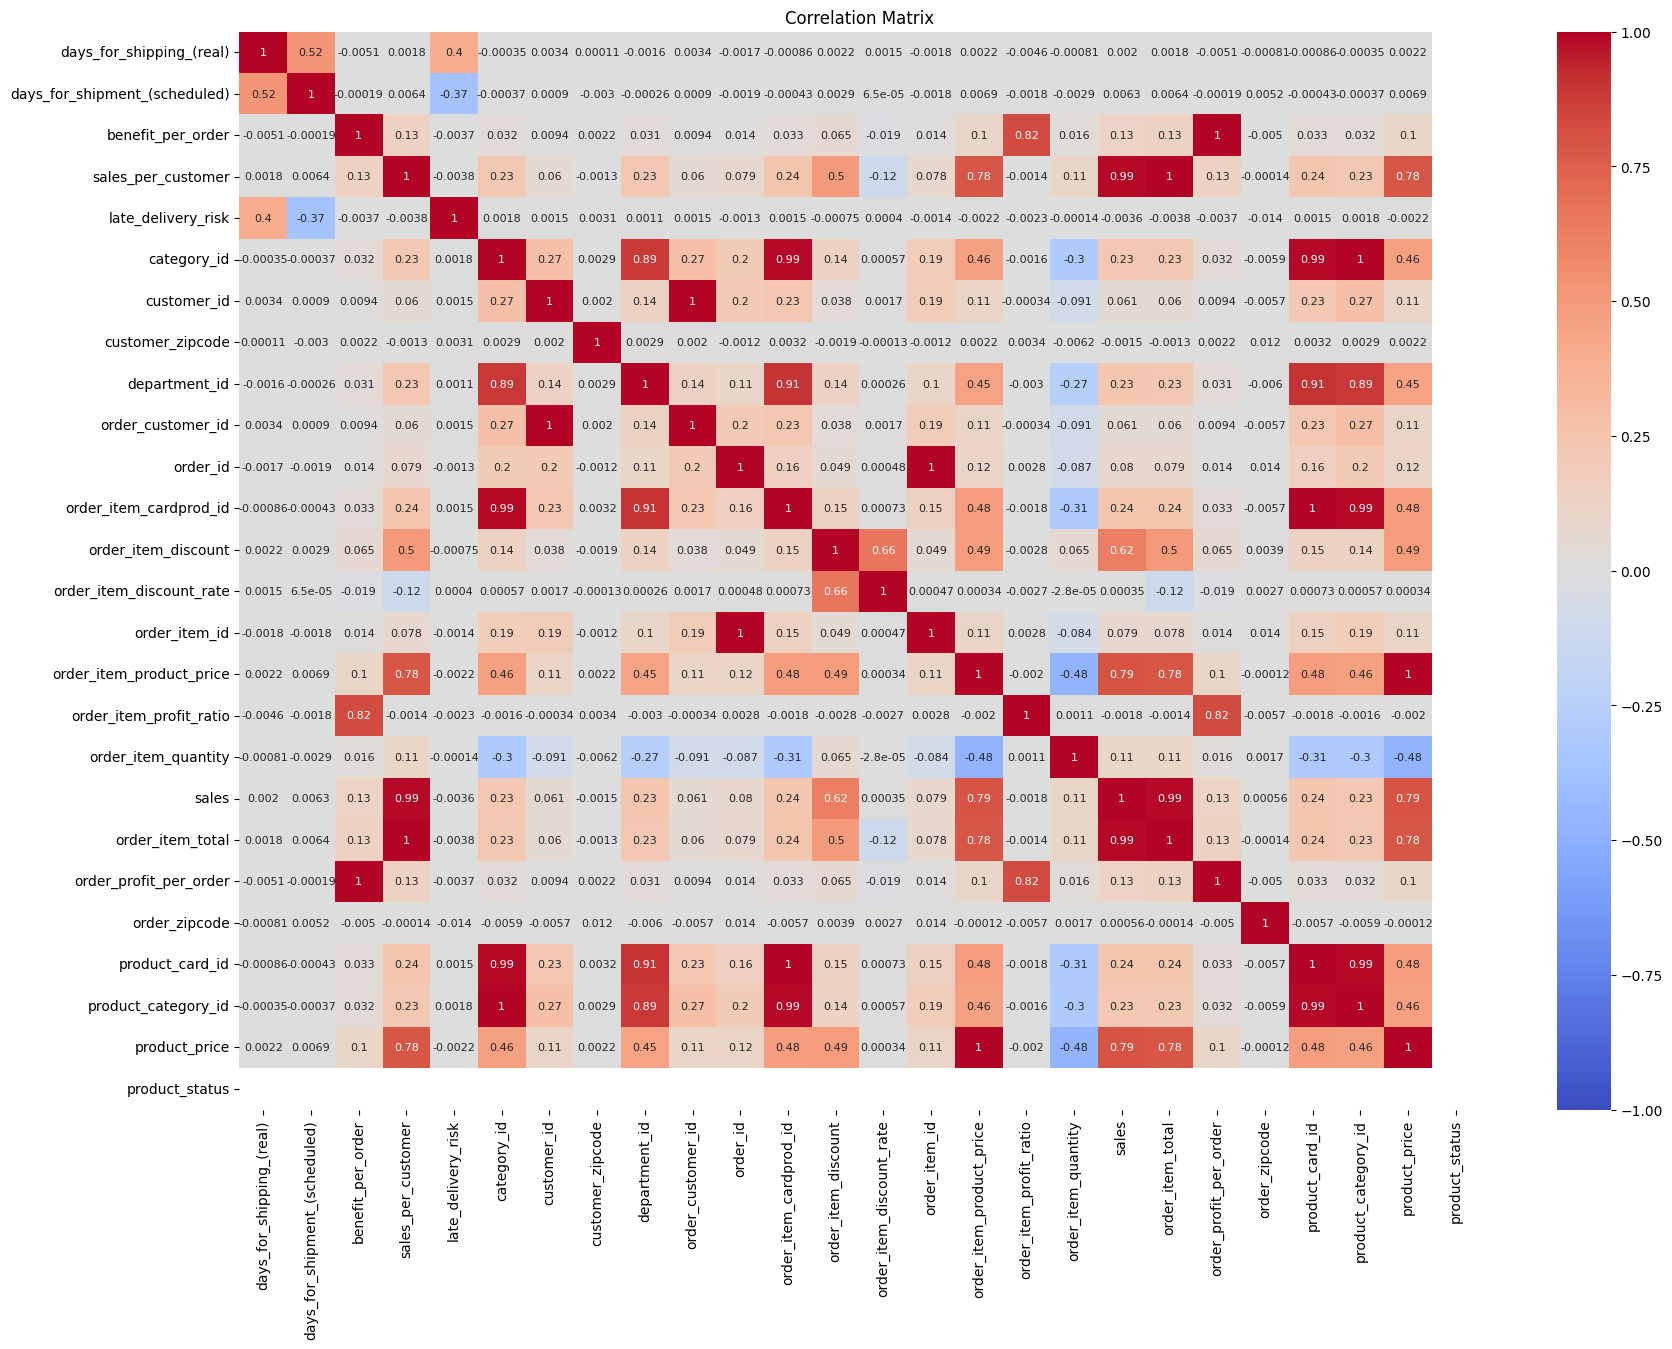

In [47]:
df_numeric = df_pandas.select_dtypes(include='number')
corr_matrix = df_numeric.corr()

plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [50]:
df.select('order_item_discount','order_item_discount_rate',
          'order_item_profit_ratio','order_item_quantity',
          'sales','order_item_total','order_profit_per_order',
          'product_price', 'benefit_per_order').show(5)

+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+-------------+-----------------+
|order_item_discount|order_item_discount_rate|order_item_profit_ratio|order_item_quantity| sales|order_item_total|order_profit_per_order|product_price|benefit_per_order|
+-------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+-------------+-----------------+
|        13.10999966|             0.039999999|            0.289999992|                  1|327.75|     314.6400146|                 91.25|       327.75|            91.25|
|        16.38999939|             0.050000001|           -0.800000012|                  1|327.75|     311.3599854|          -249.0899963|       327.75|     -249.0899963|
|        18.03000069|             0.059999999|           -0.800000012|                  1|327.75|     309.7200012|          -247.7799988|       327.75

When you do some basic math you will find these below relationship among these columns:-

* Sales = Product Price * Order Item Quantity
* Order Item Total = Sales - Order Item Discount
* Order Item Discount = Sales * Order Item Discount Rate
* Order Profit Per Order= Order Item Total * Order Item Profit Ratio

These are perfect multi colinear features that shouldn't be passed on to regression models because it affects the performance of the model. You can drop one of the features from each of the above relationship.

In [56]:
spark.sql("""Select distinct(department_name) 
          FROM my_table
          """).show()

+------------------+
|   department_name|
+------------------+
|              Golf|
|           Apparel|
|          Outdoors|
|           Fitness|
|          Footwear|
|Health and Beauty |
|          Fan Shop|
|        Technology|
|        Discs Shop|
|         Book Shop|
|          Pet Shop|
+------------------+



In [55]:
spark.sql("""Select * 
          FROM my_table
          WHERE product_card_id = 365
          AND order_date <= '2017-01-01'
          """).show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+-------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+-------------+--------------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+----------------+---------------+-------------+---------------+-------------------+--------------------+-------------+--------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|  delivery_status|late_delivery_risk|category_id|category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|custo

In [24]:
spark.sql("""Select *
          From my_table
          where product_name = 'Smart watch '    
          """).show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer|  delivery_status|late_delivery_risk|category_id| category_name| customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|depa

In [27]:
spark.sql("""Select distinct product_name, product_card_id
          From my_table
          where product_name = 'Smart watch '    
          """).toPandas()

,product_name,product_card_id
0,Smart watch,1360


In [72]:
data = df.select('days_for_shipping_(real)')
data = data.withColumnRenamed('days_for_shipping_(real)', 'shipping_time')
data.groupBy('shipping_time').count().orderBy('count', ascending = False).show()

+-------------+-----+
|shipping_time|count|
+-------------+-----+
|            2|56618|
|            3|28765|
|            6|28723|
|            4|28513|
|            5|28163|
|            0| 5080|
|            1| 4657|
+-------------+-----+



## Data Modelling

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [22]:
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+----------+-------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_nam

In [24]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="type", outputCol="payment_type") 
indexed = indexer.fit(df).transform(df) 
indexed.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+----------+-------------+------------+
|    type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|d

In [116]:
temp_df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_ship_time')
temp_df = temp_df.withColumnRenamed('days_for_shipment_(scheduled)', 'estimated_ship_time')
temp_df.createOrReplaceTempView('temp_table')

In [135]:
spark.sql("""
          With T1 as (Select 
          estimated_ship_time - actual_ship_time as difference,
          Case when difference >= 0 then 1 else 0 End as on_time,
          Case when difference < 0 then 1 else 0 End as late
          from temp_table),
          T2 as (Select 
          difference,
          Count(difference) as count
          from T1
          group by difference
          order by count desc),
          T3 as (
          Select 
          Sum(on_time) as on_time,
          Sum(late) as late_delivery
          From T1)
          select * from T2
          """).show()

+----------+-----+
|difference|count|
+----------+-----+
|        -1|60647|
|         0|33753|
|        -2|28718|
|         1|21700|
|         2|21666|
|        -3| 7052|
|        -4| 6983|
+----------+-----+



In [46]:
spark.sql("""Select
          product_name, product_card_id,
          sum(order_item_quantity) as quantity
          from my_table
          group by product_name, product_card_id
          order by quantity desc
          """).toPandas().to_csv('product_by_quantity.csv', encoding='utf-8', index=False)

In [39]:
spark.sql("""Select
          product_name, product_card_id,
          sum(order_item_quantity) as quantity
          from my_table
          group by product_name, product_card_id
          order by quantity desc
          """).toPandas()

,product_name,product_card_id,quantity
0,Perfect Fitness Perfect Rip Deck,365,73698
1,Nike Men's Dri-FIT Victory Golf Polo,502,62956
2,O'Brien Men's Neoprene Life Vest,1014,57803
3,Nike Men's Free 5.0+ Running Shoe,191,36680
4,Under Armour Girls' Toddler Spine Surge Runni,627,31735
...,...,...,...
113,Stiga Master Series ST3100 Competition Indoor,127,27
114,SOLE E35 Elliptical,208,15
115,Bushnell Pro X7 Jolt Slope Rangefinder,860,11
116,SOLE E25 Elliptical,60,10


In [32]:
demand = spark.sql("""
          Select order_date,
          sum(order_item_quantity) as quantity
          from my_table
          where order_date between '2015-12-01' and '2018-02-01'
          and product_card_id = 1360
          group by order_date
          order by order_date
          """).toPandas()
demand.head(5)

,order_date,quantity
0,2017-12-02,18
1,2017-12-03,69
2,2017-12-04,58
3,2018-01-10,38
4,2018-01-11,68


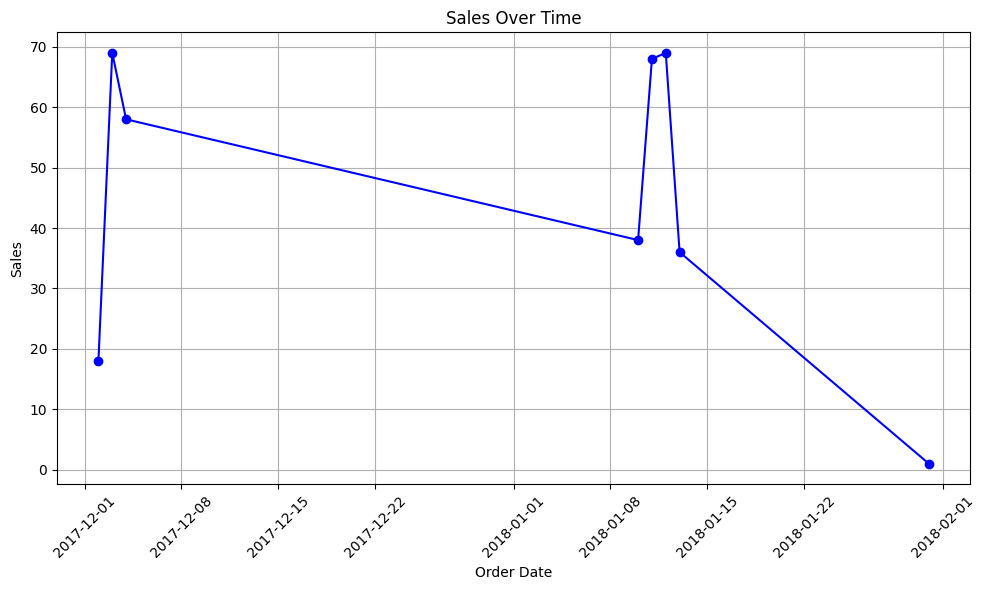

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(demand['order_date'], demand['quantity'], marker='o', color='b')

# Add labels and title
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Importance

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(training_data=X_train.values, feature_names=X_train.columns, class_names=['0','1','2','3','4','5','6'], mode='classification')

explanation = explainer.explain_instance(X_train.iloc[0], model.predict_proba)

feature_importance = explanation.as_list()

In [ ]:
feature_importance

In [ ]:
features, scores = zip(*feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(features, scores)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (Decision Tree)')
plt.show()